In [27]:
! pip install graphviz

# Sentimental Analysis

In [1]:
import os
import tensorflow.compat.v2 as tf 

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
tf.enable_v2_behavior()

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution 
disable_eager_execution()

In [4]:
base_dir = './'

train_dir = os.path.join(base_dir, 'train')
train_angry = os.path.join(train_dir,'angry')
train_disgusted = os.path.join(train_dir,'disgusted')
train_fearful = os.path.join(train_dir,'fearful')
train_sad = os.path.join(train_dir,'sad')
train_surprised = os.path.join(train_dir,'surprised')
train_happy = os.path.join(train_dir,'happy')

test_dir = os.path.join(base_dir, 'test')
test_angry = os.path.join(test_dir,'angry')
test_disgusted = os.path.join(test_dir,'disgusted')
test_fearful = os.path.join(test_dir,'fearful')
test_sad = os.path.join(test_dir,'sad')
test_surprised = os.path.join(test_dir,'surprised')
test_happy = os.path.join(test_dir,'happy')

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

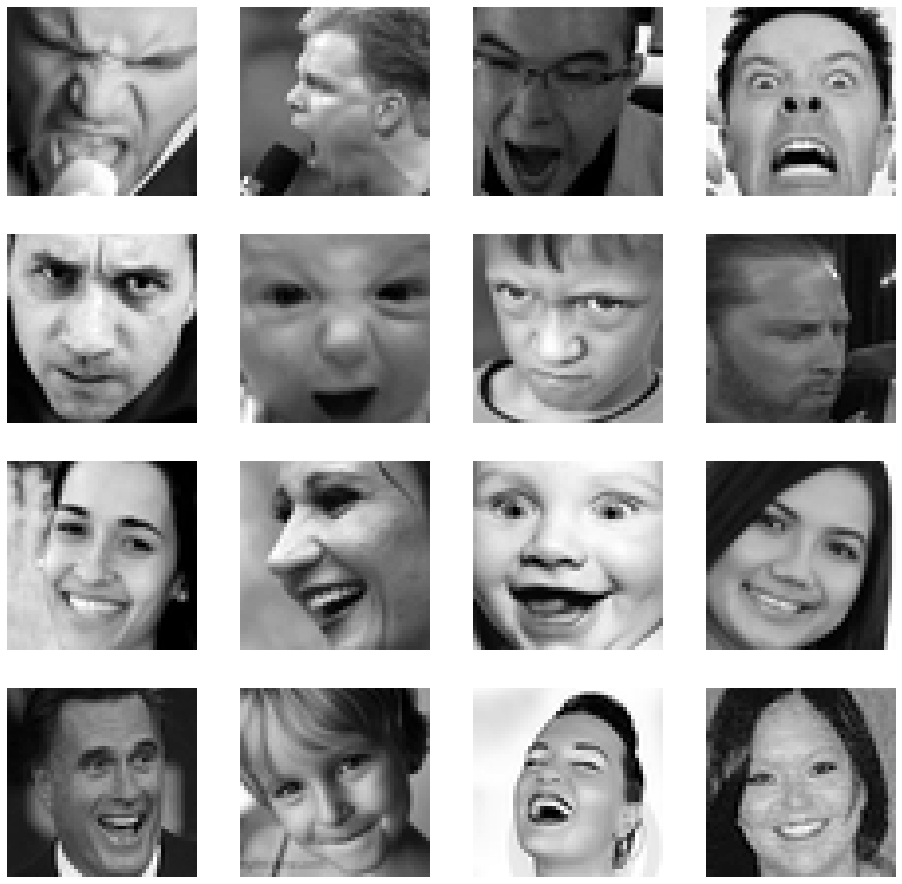

In [6]:
train_angry_fnames = os.listdir( train_angry )
train_happy_fnames = os.listdir( train_happy )

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_angry_pix = [os.path.join(train_angry, fname) 
                for fname in train_angry_fnames[ pic_index-8:pic_index] 
               ]

next_happy_pix = [os.path.join(train_happy, fname) 
                for fname in train_happy_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_angry_pix+next_happy_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 

    img = mpimg.imread(img_path)
    plt.imshow(img,cmap='gray')

plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale= 1/255.0)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'categorical',
                                                    color_mode="grayscale",
                                                    target_size = (48,48),
                                                   shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size = 64,
                                                  class_mode = 'categorical',
                                                  color_mode="grayscale",
                                                  target_size = (48,48),
                                                 shuffle = False)

Found 23743 images belonging to 6 classes.
Found 5945 images belonging to 6 classes.


In [8]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.25, patience=2, min_lr=0.00001,model='auto')

## CNN

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.metrics import Precision, Recall

model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy',Precision(), Recall()])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

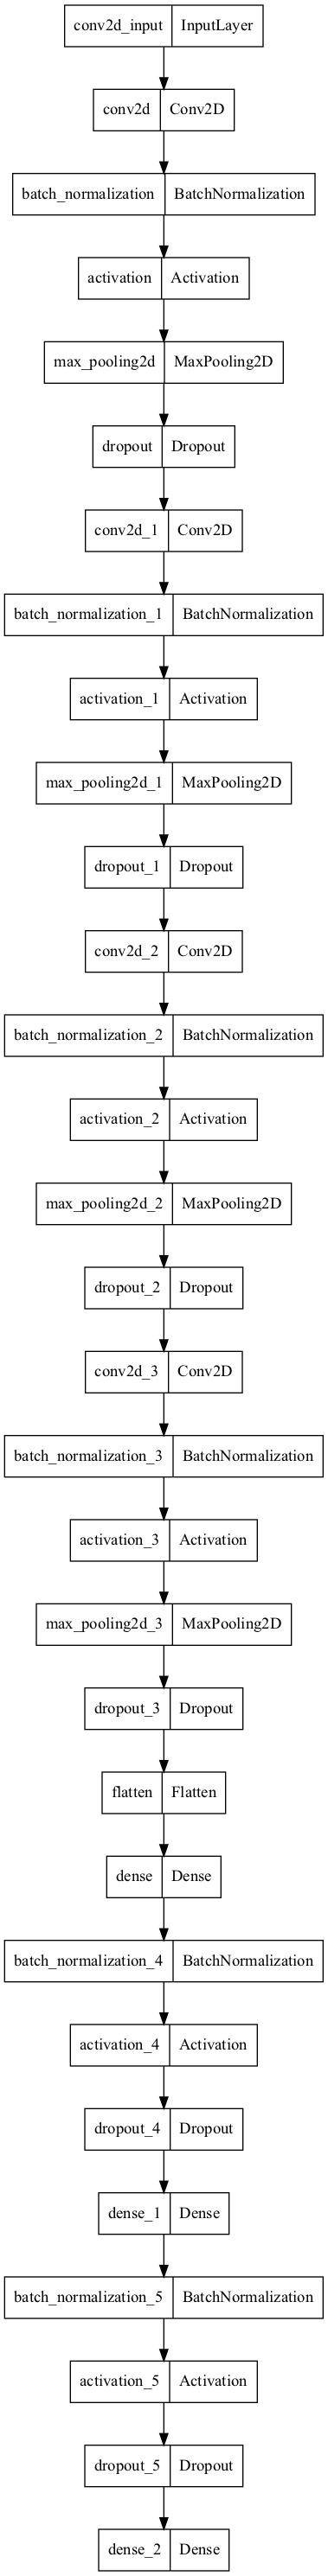

In [11]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

In [12]:
history = model.fit(train_generator,
                    validation_data=test_generator,
#                     steps_per_epoch=100,
                    epochs=100,
#                     validation_steps=50,
                    verbose=1,
                    callbacks=[reduce_lr])

Metal device set to: Apple M1


2022-01-31 20:43:35.076315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-31 20:43:35.076892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-31 20:43:35.135710: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-31 20:43:35.138069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-31 20:43:35.193845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-31 20:43:35.286328: I tensorflow/core/grappler/o

Epoch 1/100


2022-01-31 20:43:35.681259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-31 20:43:35.738228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-31 20:43:35.781486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - ETA: 0s - batch: 185.0000 - size: 63.9973 - loss: 1.6459 - accuracy: 0.3441 - precision: 0.4744 - recall: 0.1602

/Users/kimhoiin/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-01-31 20:44:31.026553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 59s 141ms/step - batch: 185.0000 - size: 63.9973 - loss: 1.6459 - accuracy: 0.3441 - precision: 0.4744 - recall: 0.1602 - val_loss: 1.5951 - val_accuracy: 0.3628 - val_precision: 0.7865 - val_recall: 0.0626 - lr: 5.0000e-04
Epoch 2/100
  1/371 [..............................] - ETA: 47s - batch: 0.0000e+00 - size: 64.0000 - loss: 1.5865 - accuracy: 0.3750 - precision: 0.5600 - recall: 0.2188

2022-01-31 20:44:34.073001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 1.3317 - accuracy: 0.4688 - precision: 0.6457 - recall: 0.2859 - val_loss: 1.2612 - val_accuracy: 0.5003 - val_precision: 0.6711 - val_recall: 0.3470 - lr: 5.0000e-04
Epoch 3/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 1.1764 - accuracy: 0.5312 - precision: 0.6938 - recall: 0.3534 - val_loss: 1.1073 - val_accuracy: 0.5610 - val_precision: 0.7353 - val_recall: 0.3850 - lr: 5.0000e-04
Epoch 4/100
371/371 [==============================] - 50s 136ms/step - batch: 185.0000 - size: 63.9973 - loss: 1.0922 - accuracy: 0.5674 - precision: 0.7247 - recall: 0.4005 - val_loss: 1.0040 - val_accuracy: 0.6094 - val_precision: 0.7520 - val_recall: 0.4452 - lr: 5.0000e-04
Epoch 5/100
371/371 [==============================] - 51s 136ms/step - batch: 185.0000 - size: 63.9973 - loss: 1.0349 - accuracy: 0.5945 - precision: 0.7341 - recall: 0.4360 

2022-01-31 20:48:45.800221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 50s 136ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.9221 - accuracy: 0.6394 - precision: 0.7652 - recall: 0.4930 - val_loss: 0.9139 - val_accuracy: 0.6410 - val_precision: 0.7604 - val_recall: 0.5156 - lr: 1.2500e-04
Epoch 8/100
371/371 [==============================] - 50s 136ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.9043 - accuracy: 0.6471 - precision: 0.7642 - recall: 0.5103 - val_loss: 0.9036 - val_accuracy: 0.6449 - val_precision: 0.7533 - val_recall: 0.5248 - lr: 1.2500e-04
Epoch 9/100
371/371 [==============================] - 50s 136ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.8863 - accuracy: 0.6542 - precision: 0.7691 - recall: 0.5274 - val_loss: 0.9500 - val_accuracy: 0.6239 - val_precision: 0.7132 - val_recall: 0.5337 - lr: 1.2500e-04
Epoch 10/100
371/371 [==============================] - 50s 136ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.8661 - accuracy: 0.6608 - precision: 0.7711 - recall: 0.5349

371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.7251 - accuracy: 0.7178 - precision: 0.7955 - recall: 0.6254 - val_loss: 0.8236 - val_accuracy: 0.6932 - val_precision: 0.7621 - val_recall: 0.6143 - lr: 1.0000e-05
Epoch 37/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.7192 - accuracy: 0.7215 - precision: 0.8024 - recall: 0.6289 - val_loss: 0.8225 - val_accuracy: 0.6897 - val_precision: 0.7595 - val_recall: 0.6126 - lr: 1.0000e-05
Epoch 38/100
371/371 [==============================] - 50s 136ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.7121 - accuracy: 0.7213 - precision: 0.8016 - recall: 0.6305 - val_loss: 0.8215 - val_accuracy: 0.6942 - val_precision: 0.7614 - val_recall: 0.6158 - lr: 1.0000e-05
Epoch 39/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.7217 - accuracy: 0.7182 - precision: 0.7969 - recall: 0.62

371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.6823 - accuracy: 0.7353 - precision: 0.8108 - recall: 0.6543 - val_loss: 0.8178 - val_accuracy: 0.6962 - val_precision: 0.7644 - val_recall: 0.6256 - lr: 1.0000e-05
Epoch 66/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.6829 - accuracy: 0.7362 - precision: 0.8092 - recall: 0.6556 - val_loss: 0.8266 - val_accuracy: 0.6945 - val_precision: 0.7612 - val_recall: 0.6289 - lr: 1.0000e-05
Epoch 67/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.6829 - accuracy: 0.7302 - precision: 0.8053 - recall: 0.6513 - val_loss: 0.8288 - val_accuracy: 0.6939 - val_precision: 0.7538 - val_recall: 0.6289 - lr: 1.0000e-05
Epoch 68/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.6772 - accuracy: 0.7364 - precision: 0.8067 - recall: 0.65

371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.6515 - accuracy: 0.7499 - precision: 0.8170 - recall: 0.6746 - val_loss: 0.8144 - val_accuracy: 0.7034 - val_precision: 0.7642 - val_recall: 0.6400 - lr: 1.0000e-05
Epoch 95/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.6457 - accuracy: 0.7488 - precision: 0.8129 - recall: 0.6742 - val_loss: 0.8184 - val_accuracy: 0.7028 - val_precision: 0.7614 - val_recall: 0.6377 - lr: 1.0000e-05
Epoch 96/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.6422 - accuracy: 0.7530 - precision: 0.8202 - recall: 0.6788 - val_loss: 0.8145 - val_accuracy: 0.7034 - val_precision: 0.7621 - val_recall: 0.6387 - lr: 1.0000e-05
Epoch 97/100
371/371 [==============================] - 50s 135ms/step - batch: 185.0000 - size: 63.9973 - loss: 0.6412 - accuracy: 0.7510 - precision: 0.8165 - recall: 0.67

Text(0.5, 1.0, 'Training and validation loss')

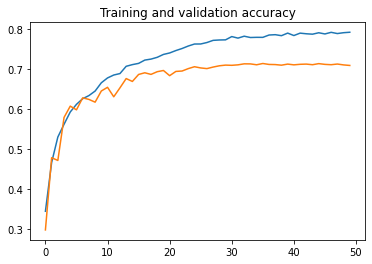

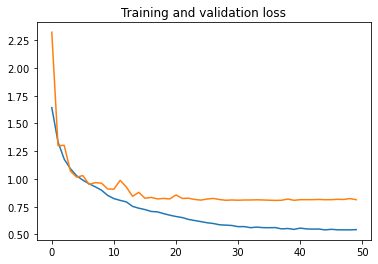

In [15]:
acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [16]:
model.save('CNN_7.h5')

2022-01-30 17:44:19.692134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:44:19.708880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:44:19.729274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:44:19.746021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:44:19.759068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:44:19.771191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:44:19.783161: I tensorflow/core/grappler/optimizers/cust

## ResNet

In [17]:
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall

In [18]:
resnet = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top= False, 
                                                input_shape=(48,48,3)) 

vgg16 = tf.keras.applications.vgg16.VGG16(weights=None,include_top=False,
                                             input_shape=(48,48,3))

vgg19 = tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False,
                                             input_shape=(48,48,3))

2022-01-30 17:47:20.390395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:47:20.615830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:47:21.045938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:47:21.723866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:47:21.901086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:47:22.080267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [11]:
for layer in resnet.layers:
    layer.trainable = False

for layer in vgg16.layers:
    layer.trainable = False
    
for layer in vgg19.layers:
    layer.trainable = False

In [20]:
input_tensor = Input(shape=(48,48,1))
x = layers.Conv2D(3,(1,1),padding='same')(input_tensor)
# x = resnet(x) 
x = vgg16(x)
x = layers.Flatten()(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.25)(x)
out = layers.Dense(6, activation='softmax')(x)

model_2 = Model(inputs=input_tensor, outputs=out)

model_2.compile(optimizer=Adam(learning_rate= 0.00005),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy',Precision(), Recall()])
#Precision : 예측한 것 중 실제로 맞은 것
#Recall : 실제 참값 중 예측을 잘 한 것

In [21]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 3)         6         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 3078  

In [22]:
history_2 = model_2.fit(train_generator,
                        validation_data=test_generator,
                        epochs=50,
                        verbose=1,
                         callbacks=[reduce_lr])

2022-01-30 17:48:35.553922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:48:35.725613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:48:35.806810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:48:35.978806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:48:36.156772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2022-01-30 17:48:36.473224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:48:36.669457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-30 17:48:36.769574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


164/371 [============>.................] - ETA: 44s - batch: 81.5000 - size: 63.9939 - loss: 1.6628 - accuracy: 0.3005 - precision_1: 0.3500 - recall_1: 6.6698e-04

KeyboardInterrupt: 

In [ ]:
model_2.save('Resnet_3.h5')